In [2]:
## Header files 
from two_TrAdaBoostR2 import TwoStageTrAdaBoostR2 ##For STrAdaBoost.R2
from TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2 ## For two-stage TrAdaBoost.R2

import pandas as pd
import sys
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Conv2D, Dropout, Flatten
from keras import optimizers, utils, initializers, regularizers
import keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler #Importing the StandardScaler

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr
from math import sqrt

#Geo plotting libraries
#import geopandas as gdp
#from matplotlib.colors import ListedColormap
#import geoplot as glpt

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
import matplotlib.lines as mlines
import folium
import glob

from statistics import mean

pd.options.display.max_columns = None

##Uploading the Instance Weighing Kernel Ridge Regression library
from IW_KRR import InstanceKRR


print("Done uploading repositories")

Done uploading repositories


/Users/shrey/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
############################## UCI Italian dataset #######################################################

aqi_df = pd.read_csv('AQI_datasets/UCI_AQI/AirQualityUCI.csv', sep=',', delimiter=";", decimal=",", index_col = None, header=0)

aqi_df.head(20)
print(aqi_df.shape)
print(aqi_df.columns)

## Predictors: T,Ah,Rh, NMHC_GT, NOx_GT, CO_GT, C6H6_GT ,Target: O3 

(9471, 17)
Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'NOx_GT', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [6]:
def remove_outlier(col):
    aqi_df[col] = aqi_df.groupby('Date')[col].transform(lambda x: x.fillna(x.mean()))


#drop end rows with NaN values
aqi_df.dropna(how = 'all', inplace = True)

drop_unamed = ['Unnamed: 15', 'Unnamed: 16']
aqi_df = aqi_df.drop(drop_unamed, axis = 1)
aqi_df.columns
print(aqi_df.shape)
aqi_df

#Observing data statistics
aqi_df.describe()

#Drop unwanted columns
drop_uw = ['Time', 'PT08_S1_CO', 'PT08_S2_NMHC', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2']
aqi_df = aqi_df.drop(drop_uw, axis = 1)
aqi_df

#Replace the -200 values seen in the dataset with 
aqi_df.replace(to_replace = -200, value = np.NaN, inplace = True)

#Replace the NaN values with the column mean
col_list = aqi_df.columns[1:]
for i in col_list:
    remove_outlier(i)

aqi_df.fillna(method ='ffill', inplace= True)
aqi_df.dropna(axis = 0)
aqi_df

#Convert 'Date' column to datetime and then seperate out year and month into different columns.
aqi_df.Date = pd.to_datetime(aqi_df.Date)
aqi_df['Year'] = aqi_df['Date'].dt.year
aqi_df['Month'] = aqi_df['Date'].dt.month
drop_date = ['Date']
aqi_df = aqi_df.drop(drop_date, axis = 1)
aqi_df

(9357, 15)


,CO_GT,NMHC_GT,C6H6_GT,NOx_GT,PT08_S5_O3,T,RH,AH,Year,Month
0,2.6,150.0,11.9,166.0,1268.0,13.6,48.9,0.7578,2004,10
1,2.0,112.0,9.4,103.0,972.0,13.3,47.7,0.7255,2004,10
2,2.2,88.0,9.0,131.0,1074.0,11.9,54.0,0.7502,2004,10
3,2.2,80.0,9.2,172.0,1203.0,11.0,60.0,0.7867,2004,10
4,1.6,51.0,6.5,131.0,1110.0,11.2,59.6,0.7888,2004,10
...,...,...,...,...,...,...,...,...,...,...
9352,3.1,275.0,13.5,472.0,1729.0,21.9,29.3,0.7568,2005,4
9353,2.4,275.0,11.4,353.0,1269.0,24.3,23.7,0.7119,2005,4
9354,2.4,275.0,12.4,293.0,1092.0,26.9,18.3,0.6406,2005,4
9355,2.1,275.0,9.5,235.0,770.0,28.3,13.5,0.5139,2005,4


In [9]:
#Split the dataset according to the year.
aqi_df_2004 = aqi_df[aqi_df['Year'] == 2004]
aqi_df_2005 = aqi_df[aqi_df['Year'] == 2005]

aqi_df_2004 = aqi_df_2004.reset_index(drop=True)
aqi_df_2005 = aqi_df_2005.reset_index(drop=True)


#Divide the dataframe into target and the predictors.
target_uci_col = ['PT08_S5_O3']
aqi_df_2004_target = aqi_df_2004[target_uci_col]
aqi_df_2004_target.columns = ['O3']

aqi_df_2005_target = aqi_df_2005[target_uci_col]
aqi_df_2005_target.columns = ['O3']

aqi_df_2004_predictors = aqi_df_2004.drop(target_uci_col, axis = 1)
aqi_df_2004_predictors.columns = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']

aqi_df_2005_predictors = aqi_df_2005.drop(target_uci_col, axis = 1)
aqi_df_2005_predictors.columns = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']

aqi_df_2004_target
aqi_df_2004_predictors

aqi_df_2005_target
aqi_df_2005_predictors

,CO,NMHC,C6H6,NOx,Temp,RH,AH,Year,Month
0,2.134783,275.0,4.2,311.181818,8.2,40.1,0.4375,2005,1
1,1.600000,275.0,8.8,215.000000,5.3,50.7,0.4564,2005,1
2,2.500000,275.0,7.5,300.000000,5.9,50.0,0.4689,2005,1
3,2.700000,275.0,7.6,311.181818,4.9,53.9,0.4693,2005,1
4,1.900000,275.0,5.6,253.000000,4.3,55.3,0.4650,2005,1
...,...,...,...,...,...,...,...,...,...
2242,3.100000,275.0,13.5,472.000000,21.9,29.3,0.7568,2005,4
2243,2.400000,275.0,11.4,353.000000,24.3,23.7,0.7119,2005,4
2244,2.400000,275.0,12.4,293.000000,26.9,18.3,0.6406,2005,4
2245,2.100000,275.0,9.5,235.000000,28.3,13.5,0.5139,2005,4


In [10]:
## Standardize the dataset
columns_uci = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH', 'Year', 'Month']
cols_to_norm = ['CO', 'NMHC', 'C6H6', 'NOx', 'Temp', 'RH', 'AH']

ss = StandardScaler()
aqi_df_2004_predictors[cols_to_norm] = ss.fit_transform(aqi_df_2004_predictors[cols_to_norm])
aqi_df_2005_predictors[cols_to_norm] = ss.fit_transform(aqi_df_2005_predictors[cols_to_norm])

aqi_df_2004_predictors
# aqi_df_2005_predictors

,CO,NMHC,C6H6,NOx,Temp,RH,AH,Year,Month
0,0.357434,-1.403072,0.167727,-0.251434,-0.897718,0.030505,-1.028223,2004,10
1,-0.073637,-1.872833,-0.163670,-0.580486,-0.935168,-0.038507,-1.115824,2004,10
2,0.070053,-2.169524,-0.216693,-0.434241,-1.109937,0.323803,-1.048835,2004,10
3,0.070053,-2.268421,-0.190181,-0.220095,-1.222288,0.668860,-0.949843,2004,10
4,-0.361018,-2.626923,-0.548090,-0.434241,-1.197321,0.645856,-0.944148,2004,10
...,...,...,...,...,...,...,...,...,...
7105,-0.648398,0.142195,-0.707160,-0.256657,-1.434508,-0.849390,-2.010003,2004,12
7106,-0.648398,0.142195,-0.707160,-0.256657,-1.397057,-0.924153,-2.033598,2004,12
7107,-0.648398,0.142195,-0.680649,-0.256657,-1.459475,-0.912651,-2.062075,2004,12
7108,-0.648398,0.142195,-0.667393,-0.256657,-1.459475,-0.642356,-1.914537,2004,12


In [14]:
#Splitting dataset into train, test and source.
X_2005_train, X_2005_test, y_2005_train, y_2005_test = train_test_split(aqi_df_2005_predictors, aqi_df_2005_target, test_size = 0.96, random_state = 1)

### 2004 X and Y dataset
X_2004 = aqi_df_2004_predictors
y_2004 = aqi_df_2004_target

### We already ahve the 2005 train and test dataset
X_2005_train.shape
X_2005_test.shape


(89, 9)

In [41]:
np_test_X = X_2005_test.to_numpy()
np_test_y = y_2005_test.to_numpy()

# np_TF_train_y_list = np_TF_train_y.ravel()
np_test_y_list = np_test_y.ravel()

np_test_y_list

array([ 451.,  682., 1450., ..., 2086.,  282., 1395.])

In [42]:
##Fit the data
krr = InstanceKRR(lmbd = 0.5)
krr.fit(X_2004,y_2004)

In [43]:
yhat = krr.kRR_predict(np_test_X)
yhat

array([[ 395.57405213],
       [ 494.15403138],
       [1191.02738413],
       ...,
       [1554.15431898],
       [ 403.90374219],
       [1133.91661762]])

In [44]:
##Find alpha weights
krr.Solve_alpha(X_2005_train,y_2005_train)

In [45]:
##Make the prediction
y_prd = krr.predict(np_test_X)

In [46]:
y_prd = y_prd.ravel()
y_prd

array([ 546.16009433,  518.28159374, 1209.98815359, ..., 1339.5592793 ,
        423.29609543, 1476.59888148])

In [47]:
r2_score_IWKRR_values = pearsonr(np_test_y_list, y_prd)
r2_score_IWKRR = (r2_score_IWKRR_values[0])**2
print("R^2 of IWKRR:", r2_score_IWKRR)

R^2 of IWKRR: 0.6300624048877762


In [48]:
mse_IWKRR = np.sqrt(mean_squared_error(np_test_y_list, y_prd))
print("RMSE of IWKRR:", mse_IWKRR)



RMSE of IWKRR: 284.63361482814236


In [51]:

# #Plot results
# plt.figure(figsize=(10, 5))
# lw = 2
# plt.scatter(X_2004, np.array(y_2004), c='k', label='data w\ noise')
# plt.plot(np_test_X, yhat, c='g', lw = 5, label='KRR')

# plt.scatter(X_2005, np.array(y_2005), c = 'r', label = "Auxilary data")
# plt.plot(np_test_X, y_prd, c = 'r', lw = 5, label = "Instance weighted KRR")
# plt.plot(np_test_X, np.sin(np_test_X), color='navy', lw=lw, label='True value')
# plt.legend()
# plt.show()

In [64]:
################# UCI Beijing dataset (2013 - 2017) #####################################################################
############### Spacio-temporal dataset. (multi-year and multi-terrain)
# beijing_aqi_df = pd.read_csv('AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv') 
# drop_index = ['No']
# beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)
# #print(beijing_aqi_df.head())
# print(beijing_aqi_df.isnull().sum())

path_beijing = r'AQI_datasets/Beijing_AQI/PRSA_Data_20130301-20170228/' ## Path for all the files
allFiles = glob.glob(path_beijing + "/*.csv")
beijing_aqi_df = pd.DataFrame()
list_beijing = []
for file_ in allFiles:
    temp_df = pd.read_csv(file_, index_col = None, header=0)
    list_beijing.append(temp_df)
beijing_aqi_df = pd.concat(list_beijing)

cols = ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

beijing_aqi_df = beijing_aqi_df[cols]

drop_index = ['No']
beijing_aqi_df = beijing_aqi_df.drop(drop_index, axis=1)

beijing_aqi_df = beijing_aqi_df.sort_values(['station', 'year'])

beijing_aqi_df.head(20)
# beijing_aqi_df.year.value_counts()
# beijing_aqi_df.wd.value_counts()
# beijing_aqi_df.shape
beijing_aqi_df['station'].nunique()
beijing_aqi_df.columns
## O3: Dependent, Predictors: SO2, NO2, year, month, CO
## PM25: Dependent, Predictors:

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [65]:
## Seperate the dataset into predictors and target variable.
predictors = ['year', 'month', 'SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'O3']
beijing_predictors_df = beijing_aqi_df[predictors]
wd_codes = {'N':1, 'E': 2, 'W': 3, 'S': 4, 'NE': 5, 'NW': 6, 'SE': 7, 'SW': 8, 'NNE': 9, 'NNW': 10, 'SSE': 11, 
            'SSW': 12, 'WNW': 13, 'WSW': 14, 'ENE': 15, 'ESE': 16 }
beijing_predictors_df.replace(wd_codes, inplace=True)
beijing_predictors_df.wd.value_counts()
beijing_predictors_df

# target = ['O3']
# beijing_target_df = beijing_aqi_df[target]
# beijing_target_df

/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,O3
0,2013,3,4.0,7.0,300.0,-0.7,1023.0,-18.8,0.0,10.0,4.4,Aotizhongxin,77.0
1,2013,3,4.0,7.0,300.0,-1.1,1023.2,-18.2,0.0,1.0,4.7,Aotizhongxin,77.0
2,2013,3,5.0,10.0,300.0,-1.1,1023.5,-18.2,0.0,10.0,5.6,Aotizhongxin,73.0
3,2013,3,11.0,11.0,300.0,-1.4,1024.5,-19.4,0.0,6.0,3.1,Aotizhongxin,72.0
4,2013,3,12.0,12.0,300.0,-2.0,1025.2,-19.5,0.0,1.0,2.0,Aotizhongxin,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,3.0,24.0,400.0,12.5,1013.5,-16.2,0.0,6.0,2.4,Wanshouxigong,72.0
35060,2017,2,3.0,41.0,500.0,11.6,1013.6,-15.1,0.0,13.0,0.9,Wanshouxigong,50.0
35061,2017,2,4.0,38.0,500.0,10.8,1014.2,-13.3,0.0,6.0,1.1,Wanshouxigong,54.0
35062,2017,2,4.0,30.0,400.0,10.5,1014.4,-12.9,0.0,10.0,1.2,Wanshouxigong,59.0


In [66]:
############# Replacing missing values ##############################################################
# beijing_predictors_df['SO2'].fillna(beijing_predictors_df['SO2'].median(), inplace=True)
# beijing_predictors_df['NO2'].fillna(beijing_predictors_df['NO2'].mean(), inplace=True)
# beijing_predictors_df['CO'].fillna(beijing_predictors_df['CO'].median(), inplace=True)
# beijing_predictors_df['O3'].fillna(beijing_predictors_df['O3'].median(), inplace=True)
                                   
# beijing_predictors_df = beijing_predictors_df.dropna(axis=0) # , subset=['O3'])

###### percentage of missing values in each column #####################################3
round(beijing_predictors_df.isna().sum()/len(beijing_predictors_df.index), 2)*100

year       0.0
month      0.0
SO2        2.0
NO2        3.0
CO         5.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
O3         3.0
dtype: float64

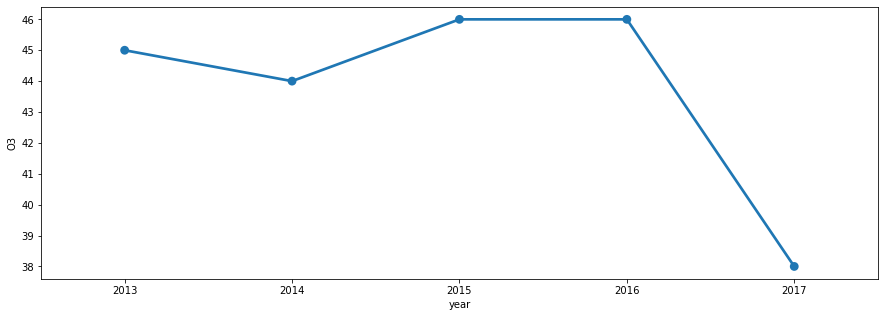

In [67]:
###### plotting concentration of PM 2.5 values over the years ###############################
df_plot_beijing = beijing_predictors_df[['O3','year','station']].groupby(["year"]).median().reset_index().sort_values(by = 'year',ascending=False)
f,ax = plt.subplots(figsize = (15,5))
sns.pointplot(x = 'year', y = 'O3', data = df_plot_beijing)

In [68]:
##Get correlation between O3 and other predictors
# corrMatrix_beijing = beijing_aqi_df.corr()
corrMatrix_beijing = beijing_predictors_df.corr()
corrMatrix_beijing["O3"].sort_values(ascending=False)

# sns.heatmap(corrMatrix_beijing, annot=True)
# plt.show()

O3       1.000000
TEMP     0.594910
DEWP     0.312074
WSPM     0.295743
wd       0.056920
RAIN     0.023320
year    -0.024384
month   -0.103691
SO2     -0.165341
CO      -0.313012
PRES    -0.445961
NO2     -0.471587
Name: O3, dtype: float64

In [69]:
### Drop stations (dropping stations at this stage so more combination of splits can be made later) ###############
drop_stations = ['station']
beijing_predictors_df = beijing_predictors_df.drop(drop_stations, axis=1)

## Splitting the dataset by the year ##############
beijing_predictors_df.year.value_counts()
beijing_predictors_df_target = beijing_predictors_df[beijing_predictors_df['year'].isin([2014, 2015])]
beijing_predictors_df_source = beijing_predictors_df[beijing_predictors_df['year'].isin([2016])]

print(beijing_predictors_df_source.shape)
print(beijing_predictors_df_target.shape)
# beijing_predictors_df_target.head(10)

(105408, 12)
(210240, 12)


In [70]:
##Standardize the dataset.

cols_to_norm = ['SO2', 'NO2', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

ss = StandardScaler()
beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
beijing_predictors_df_source[cols_to_norm] = ss.fit_transform(beijing_predictors_df_source[cols_to_norm])

beijing_predictors_df_source

<ipython-input-70-80145c68ccd4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beijing_predictors_df_target[cols_to_norm] = ss.fit_transform(beijing_predictors_df_target[cols_to_norm])
/Users/shrey/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-70-80145c68ccd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,O3
24864,2016,1,2.799574,2.289538,3.764447,-1.353274,1.239484,-0.727127,-0.085113,9.0,-0.608262,13.0
24865,2016,1,4.229429,2.169987,3.854912,-1.437461,1.174125,-0.663963,-0.085113,5.0,-0.689916,16.0
24866,2016,1,4.078918,2.050435,2.859795,-1.538486,1.164788,-0.663963,-0.085113,15.0,-0.853224,12.0
24867,2016,1,3.476874,1.930884,2.678864,-1.445880,1.108766,-0.692036,-0.085113,15.0,-0.281646,9.0
24868,2016,1,2.724319,1.811333,2.226538,-1.572161,1.034069,-0.692036,-0.085113,2.0,-0.689916,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33643,2016,12,0.015120,3.186172,3.040725,-1.302762,1.006058,-0.579745,-0.085113,16.0,-0.771570,4.0
33644,2016,12,0.165631,2.976957,2.678864,-1.353274,1.043406,-0.537635,-0.085113,15.0,-0.934877,4.0
33645,2016,12,0.165631,2.827518,2.950260,-1.395368,1.015395,-0.523599,-0.085113,2.0,-0.771570,5.0
33646,2016,12,0.165631,2.319426,3.493051,-1.395368,1.071417,-0.502544,-0.085113,8.0,-1.424801,8.0


In [71]:
###Splitting the dataset into train and test set ########
target_beijing_col = ['O3']
beijing_predictors_df_target_Y = beijing_predictors_df_target[target_beijing_col]
beijing_predictors_df_target_X = beijing_predictors_df_target.drop(target_beijing_col, axis =1)

beijing_predictors_df_source_Y = beijing_predictors_df_source[target_beijing_col]
beijing_predictors_df_source_X = beijing_predictors_df_source.drop(target_beijing_col, axis =1)


X_train, X_test, y_train, y_test = train_test_split(beijing_predictors_df_target_X, beijing_predictors_df_target_Y, test_size = 0.999, random_state = 1)

X_source = beijing_predictors_df_source_X
y_source = beijing_predictors_df_source_Y

X_train.shape, X_test.shape, X_source.shape, y_train.shape

# X_train.columns

((210, 11), (210030, 11), (105408, 11), (210, 1))

In [72]:
np_test_X = X_test.to_numpy()
np_test_y = y_test.to_numpy()

# np_TF_train_y_list = np_TF_train_y.ravel()
np_test_y_list = np_test_y.ravel()
np_test_y_list

array([122.,  86.,  44., ...,  85.,  97., 108.])

In [75]:
np_TF_train_X = X_train.to_numpy()
np_TF_train_y = y_train.to_numpy()

X_source

# ##Fit the data
# krr = InstanceKRR(lmbd = 0.5)
# krr.fit(np_TF_train_X,np_TF_train_y)

,year,month,SO2,NO2,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM
24864,2016,1,2.799574,2.289538,3.764447,-1.353274,1.239484,-0.727127,-0.085113,9.0,-0.608262
24865,2016,1,4.229429,2.169987,3.854912,-1.437461,1.174125,-0.663963,-0.085113,5.0,-0.689916
24866,2016,1,4.078918,2.050435,2.859795,-1.538486,1.164788,-0.663963,-0.085113,15.0,-0.853224
24867,2016,1,3.476874,1.930884,2.678864,-1.445880,1.108766,-0.692036,-0.085113,15.0,-0.281646
24868,2016,1,2.724319,1.811333,2.226538,-1.572161,1.034069,-0.692036,-0.085113,2.0,-0.689916
...,...,...,...,...,...,...,...,...,...,...,...
33643,2016,12,0.015120,3.186172,3.040725,-1.302762,1.006058,-0.579745,-0.085113,16.0,-0.771570
33644,2016,12,0.165631,2.976957,2.678864,-1.353274,1.043406,-0.537635,-0.085113,15.0,-0.934877
33645,2016,12,0.165631,2.827518,2.950260,-1.395368,1.015395,-0.523599,-0.085113,2.0,-0.771570
33646,2016,12,0.165631,2.319426,3.493051,-1.395368,1.071417,-0.502544,-0.085113,8.0,-1.424801
